# Milestone 1 - EDA and Preprocessing data 

***Important note*** - This is merely a template. you are more than free to change how it looks or create one from scratch.

- Load dataset
- Explore the dataset and ask atleast 5 questions to give you a better understanding of the data provided to you. 
- Visualise the answer to these 5 questions.
- Cleaning the data
    - Tidy up the column names, make sure there is no spaces
    - Observe,comment on and handle inconsistent data.(i.e duplicates, irrelevant data,incorrect data,etc)
    - Observe missing data and comment on why you believe it is missing(MCAR,MAR or MNAR).
    - Handle missing data
    - Observe and comment on outliers
    - Handle outliers
- With every change you are making to the data you need to comment on why you used this technique and how has it affected the data(by both showing the change in the data i.e change in number of rows/columns,change in distrubution, etc and commenting on it).
- Data transformation and feature engineering
    - Add 2 new columns named 'Week number' and 'Date range' and discretize the data into weeks according to the dates. 
        - Tip: Change the datatype of the date feature to datetime type instead of object.
    - Encode any categorical feature(s) and comment on why you used this technique and how the data has changed.
    - If exists , Identify feature(s) which need normalization and show your reasoning. Then choose a technique to normalize the feature(s) and comment on why you chose this technique.
- Additional data extraction
    - Add GPS coordinates for the cities/locations.
    - For this task you can extract the GPS coordinates from an API or web scraping and integrate into your csv file as new features. 
    - Tip 1 - you can find the web scraping and data integration notebooks under 'additional resources'  on the CMS useful.
    - Tip 2 - If you are going to use an API make sure you do not make request for each existing row but rather group by the cities and get their respective coordinates. Making a request for each row is too inefficient and expensive.
    - Tip 3 - Rather than running the code for calling the API each time you load the notebook, the first time you call the API save the results in a csv file and then you could you check if a csv file exists for the GPS coordinates, if so, load directly and don't call APi. Same applies for web scraping.

- Lookup table and load back into new csv file
    - Create a lookup table
    - Load the new dataset into a new csv file named `green_trip_data_{year}-{month}clean.csv`. replace year and month with the appropriate values.
    - Load the lookup table to a csv file called `lookup_table_green_taxis.csv` 
- Bonus: Load the dataset as a parquet file instead of a csv file(Parquet file is a compressed file format).

# 1 - extraction

In [375]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# For min_max scaling
from sklearn.preprocessing import MinMaxScaler

# For z-score scaling
from sklearn.preprocessing import StandardScaler

# For Label Encoding
from sklearn import preprocessing

In [376]:
green_taxi_df = pd.read_csv('../data/green_tripdata_2018-05.csv')
green_taxi_df_clean = green_taxi_df.copy()

In [377]:
green_taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796565 entries, 0 to 796564
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Vendor                 796565 non-null  object 
 1   lpep pickup datetime   796565 non-null  object 
 2   lpep dropoff datetime  796565 non-null  object 
 3   store and fwd flag     796565 non-null  object 
 4   Rate type              796565 non-null  object 
 5   PU Location            796565 non-null  object 
 6   DO Location            796565 non-null  object 
 7   passenger count        794848 non-null  float64
 8   trip distance          796565 non-null  float64
 9   fare amount            796565 non-null  float64
 10  extra                  371974 non-null  float64
 11  mta tax                796565 non-null  float64
 12  tip amount             796565 non-null  float64
 13  tolls amount           796565 non-null  float64
 14  ehail fee              0 non-null   

# 3 - Cleaning Data

## Tidying up column names

In [378]:
def rename_columns(df):
#     make all cols lower case
    df.columns = df.columns.str.lower()

    df.columns = [col.replace(' ', '_') for col in df.columns]
    


In [379]:
rename_columns(green_taxi_df_clean)
green_taxi_df_clean.columns

Index(['vendor', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'rate_type', 'pu_location', 'do_location',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

# Observe inconsistent data

### duplicate data

In [380]:
green_taxi_df_clean.duplicated().sum()

7

In [381]:
green_taxi_df_clean.duplicated(subset=['lpep_pickup_datetime', 'lpep_dropoff_datetime','pu_location', 'do_location','trip_distance']).sum()

1997

In [382]:
green_taxi_df_clean.duplicated(subset=['lpep_pickup_datetime', 'lpep_dropoff_datetime','pu_location', 'do_location','trip_distance','fare_amount']).sum()

7

In [383]:
green_taxi_df_clean = green_taxi_df_clean.drop_duplicates(subset=['lpep_pickup_datetime', 'lpep_dropoff_datetime','pu_location', 'do_location','trip_distance'], keep='last')

In [384]:
green_taxi_df_clean.duplicated().sum()

0

### Findings and conclusions

there were 7 duplicate rows in the dataset when checking for duplicates in the entire row.
after using a subset that has the pick and dropoff time and location and distance(to make sure its the exact same trip) we found 1997 trips that were most likely double entries due to some change in one of the features.we investigated further and found that the only difference that was consistent between between the double entries (repeated in all entries) was the fare amount.there were other features that changes across the duplicates like improvement surcharge and other money related features but they're irrelevant as the fare amount covers all 1997 duplicates. we decided to keep the second entry as it's the updated value.
final result is 1997 rows dropped,including identical rows and rows with the same pick up and drop off location and time and distance but different fare amount.


### irrelevant or incorrect data

In [385]:
green_taxi_df_clean[pd.to_datetime(green_taxi_df_clean['lpep_pickup_datetime']).dt.year != 2018].shape


(15, 20)

In [386]:
#keep only trips that happen in 2018
green_taxi_df_clean['lpep_pickup_datetime'] = pd.to_datetime(green_taxi_df_clean['lpep_pickup_datetime'])
green_taxi_df_clean['lpep_dropoff_datetime'] = pd.to_datetime(green_taxi_df_clean['lpep_dropoff_datetime'])

green_taxi_df_clean = green_taxi_df_clean[(green_taxi_df_clean['lpep_pickup_datetime'].dt.year == 2018) & (green_taxi_df_clean['lpep_dropoff_datetime'].dt.year == 2018)]


In [387]:
green_taxi_df_clean[green_taxi_df_clean['lpep_pickup_datetime'].dt.month != 5].shape

(72, 20)

In [388]:
#keep only trips that happen in may
green_taxi_df_clean = green_taxi_df_clean[(green_taxi_df_clean['lpep_pickup_datetime'].dt.month == 5)]

In [389]:
#what defines a trip? here we remove any "trip" that has no distance, no fare, or no time or negative time
green_taxi_df_clean = green_taxi_df_clean[green_taxi_df_clean.fare_amount > 0]
green_taxi_df_clean =green_taxi_df_clean[green_taxi_df_clean.trip_distance > 0]
green_taxi_df_clean = green_taxi_df_clean[green_taxi_df_clean.lpep_pickup_datetime < green_taxi_df_clean.lpep_dropoff_datetime]


In [390]:
irrelevant = 0
irrelevant+= green_taxi_df_clean[(green_taxi_df_clean.fare_amount <=0)].shape[0]
irrelevant+= green_taxi_df_clean[(green_taxi_df_clean.trip_distance <=0)].shape[0]
irrelevant+= green_taxi_df_clean[(green_taxi_df_clean.lpep_pickup_datetime >= green_taxi_df_clean.lpep_dropoff_datetime)].shape[0]
irrelevant

0

In [391]:
green_taxi_df_clean["fare_amount"].describe()

count    783927.000000
mean         13.848657
std          11.817856
min           0.010000
25%           6.500000
50%          10.000000
75%          16.500000
max        2126.690000
Name: fare_amount, dtype: float64

In [392]:
# calculate interquartile range
Q1 = green_taxi_df_clean['fare_amount'].quantile(0.25)
Q3 = green_taxi_df_clean['fare_amount'].quantile(0.75)
IQR = Q3 - Q1

# calculate left and right whiskers for boxplot
right_whisker = Q3 + 1.5 * IQR
left_whisker = Q1 - 1.5 * IQR

# print left and right whisker
print(right_whisker, left_whisker)
print('Min fare within range:', green_taxi_df_clean['fare_amount'][green_taxi_df_clean['fare_amount'] >= left_whisker].min())
print('max fare within range:', green_taxi_df_clean['fare_amount'][green_taxi_df_clean['fare_amount'] <= right_whisker].max())


31.5 -8.5
Min fare within range: 0.01
max fare within range: 31.5


In [393]:
green_taxi_df_clean[ (green_taxi_df_clean['fare_amount'] > 100)]

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
2277,VeriFone Inc.,2018-05-01 06:32:39,2018-05-01 08:05:21,N,Standard rate,"Bronx,Parkchester","Brooklyn,Bay Ridge",1.0,38.17,107.5,NaN,0.5,0.00,5.76,NaN,0.3,114.06,Cash,Street-hail,NaN
6670,VeriFone Inc.,2018-05-01 10:41:48,2018-05-01 15:58:48,N,Nassau or Westchester,"Queens,Steinway","Queens,Jamaica Estates",1.0,53.66,429.0,NaN,0.5,0.00,0.00,NaN,0.3,429.80,Cash,Street-hail,NaN
9025,VeriFone Inc.,2018-05-01 11:02:50,2018-05-01 12:31:11,N,Standard rate,"Brooklyn,Bay Ridge","Bronx,Parkchester",1.0,37.09,104.5,NaN,0.5,0.00,5.76,NaN,0.3,111.06,Credit card,Street-hail,NaN
13930,VeriFone Inc.,2018-05-01 16:31:43,2018-05-01 18:22:15,N,Standard rate,"Manhattan,Morningside Heights","Unknown,Unknown",1.0,49.27,137.5,1.0,0.5,0.00,22.50,NaN,0.3,161.80,Cash,Street-hail,NaN
14788,VeriFone Inc.,2018-05-01 16:13:53,2018-05-01 18:13:16,N,Standard rate,"Bronx,Eastchester","Brooklyn,Flatlands",1.0,29.57,100.5,1.0,0.5,0.00,5.76,NaN,0.3,108.06,Credit card,Street-hail,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786068,VeriFone Inc.,2018-05-31 16:54:04,2018-05-31 18:05:48,N,Negotiated fare,"Queens,Glen Oaks","Unknown,Unknown",2.0,26.07,250.0,NaN,0.0,10.88,0.00,NaN,0.0,260.88,Credit card,Dispatch,NaN
786485,VeriFone Inc.,2018-05-31 16:28:27,2018-05-31 18:31:18,N,Standard rate,"Bronx,Co-Op City","Brooklyn,Bay Ridge",1.0,36.40,111.0,1.0,0.5,0.00,5.76,NaN,0.3,118.56,Credit card,Street-hail,NaN
794017,VeriFone Inc.,2018-05-31 21:32:38,2018-05-31 21:32:47,N,Negotiated fare,"Queens,Flushing Meadows-Corona Park","Queens,Flushing Meadows-Corona Park",1.0,0.05,110.0,NaN,0.0,0.00,0.00,NaN,0.0,110.00,Credit card,Dispatch,NaN
794218,VeriFone Inc.,2018-05-31 21:42:34,2018-05-31 23:14:05,N,Standard rate,"Bronx,Soundview/Castle Hill","Brooklyn,Starrett City",1.0,37.11,105.5,0.5,0.5,0.00,0.00,NaN,0.3,106.80,Credit card,Street-hail,NaN


In [394]:
green_taxi_df_clean["passenger_count"].value_counts()

passenger_count
1.0      660896
2.0       61631
5.0       27043
6.0       14389
3.0       13506
4.0        4808
7.0           6
222.0         5
8.0           1
9.0           1
Name: count, dtype: int64

In [395]:
green_taxi_df_clean[green_taxi_df_clean.passenger_count > 6]

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
884,VeriFone Inc.,2018-05-01 03:10:58,2018-05-01 03:13:12,N,Standard rate,"Manhattan,Hamilton Heights","Manhattan,Manhattanville",222.0,0.80,4.5,0.5,0.5,0.00,0.00,NaN,0.3,5.80,Cash,Street-hail,NaN
3085,VeriFone Inc.,2018-05-01 08:11:13,2018-05-01 08:24:44,N,Standard rate,"Manhattan,East Harlem North","Manhattan,Manhattanville",222.0,1.59,10.0,NaN,0.5,2.16,0.00,NaN,0.3,12.96,Credit card,Street-hail,NaN
3625,VeriFone Inc.,2018-05-01 08:33:52,2018-05-01 09:14:30,N,Standard rate,"Queens,Elmhurst","Manhattan,Manhattanville",222.0,9.56,32.5,NaN,0.5,0.00,5.76,NaN,0.3,39.06,Credit card,Street-hail,NaN
5760,VeriFone Inc.,2018-05-01 10:59:35,2018-05-01 11:04:57,N,Standard rate,"Manhattan,Central Harlem North","Manhattan,Manhattanville",222.0,1.12,6.0,NaN,0.5,1.36,0.00,NaN,0.3,8.16,Credit card,Street-hail,NaN
7073,VeriFone Inc.,2018-05-01 10:02:15,2018-05-01 10:08:33,N,Standard rate,"Manhattan,Central Harlem","Manhattan,Manhattanville",222.0,1.11,6.5,NaN,0.5,0.00,0.00,NaN,0.3,7.30,Credit card,Street-hail,NaN
42418,VeriFone Inc.,2018-05-02 18:41:51,2018-05-02 18:45:40,N,Negotiated fare,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",8.0,0.01,8.0,NaN,0.0,0.00,0.00,NaN,0.0,8.00,Cash,Dispatch,NaN
272093,VeriFone Inc.,2018-05-11 09:13:34,2018-05-11 09:46:59,N,Negotiated fare,"Manhattan,Inwood","Manhattan,Meatpacking/West Village West",9.0,11.21,9.5,NaN,0.0,0.00,0.00,NaN,0.0,9.50,Cash,Dispatch,NaN
281123,VeriFone Inc.,2018-05-11 15:58:17,2018-05-11 15:58:45,N,Negotiated fare,"Manhattan,Washington Heights South","Manhattan,Washington Heights North",7.0,0.20,7.0,NaN,0.0,1.40,0.00,NaN,0.0,8.40,Credit card,Dispatch,NaN
412676,VeriFone Inc.,2018-05-16 14:47:07,2018-05-16 15:21:45,N,Negotiated fare,"Bronx,West Concourse","Unknown,Unknown",7.0,5.65,70.0,NaN,0.0,0.00,0.00,NaN,0.0,70.00,Cash,Dispatch,NaN
512554,VeriFone Inc.,2018-05-20 03:54:10,2018-05-20 03:54:28,N,Negotiated fare,"Queens,Woodside","Queens,Woodside",7.0,0.19,7.0,NaN,0.0,2.10,0.00,NaN,0.0,9.10,Credit card,Dispatch,NaN


In [396]:
green_taxi_df_clean = green_taxi_df_clean[green_taxi_df_clean.passenger_count <= 10]

### Findings and conclusions

some trips happened out of 2018 and some out of may,2018(we're only interested in may 2018).we dropped those rows.(irrelevant data)

some trips had negative or zero distance or fare amount.we dropped those rows.(irrelevant data or incorrect data respectively)

some trips had negative or 0 time difference between pick up and drop off.we dropped those rows.(irrelevant data or incorrect data respectively)

a very small number of trips had 222 passengers which is impossible.we dropped those rows.(incorrect data)



## Observing and handling Missing Data

### observing and handling placeholders

In [397]:
green_taxi_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 782281 entries, 0 to 796564
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   vendor                 782281 non-null  object        
 1   lpep_pickup_datetime   782281 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  782281 non-null  datetime64[ns]
 3   store_and_fwd_flag     782281 non-null  object        
 4   rate_type              782281 non-null  object        
 5   pu_location            782281 non-null  object        
 6   do_location            782281 non-null  object        
 7   passenger_count        782281 non-null  float64       
 8   trip_distance          782281 non-null  float64       
 9   fare_amount            782281 non-null  float64       
 10  extra                  367656 non-null  float64       
 11  mta_tax                782281 non-null  float64       
 12  tip_amount             782281 non-null  float64  

at first glance we see that most columns either have no missing values or have a very small percentage of missing values except for the extra column and a a slightly bigger percentage than the rest in payment_type column.

we will invistigate this further and also check if each column maybe has placeholders for missing values instead of nulls but first we will drop the 2 empty columns ehail_fee and congestion_surcharge as they have no values at all.

note that :- the columns after congestion surcharge were all added by me hence they have no missing values.

In [398]:
green_taxi_df_clean = green_taxi_df_clean.drop(['ehail_fee', 'congestion_surcharge'], axis=1)


In [399]:
green_taxi_df_clean["vendor"].value_counts()

vendor
VeriFone Inc.                        653644
Creative Mobile Technologies, LLC    128637
Name: count, dtype: int64

In [400]:
green_taxi_df_clean["store_and_fwd_flag"].value_counts()

store_and_fwd_flag
N    781194
Y      1087
Name: count, dtype: int64

In [401]:
green_taxi_df_clean["rate_type"].value_counts()

rate_type
Standard rate            772059
Negotiated fare            7873
JFK                        1418
Nassau or Westchester       604
Newark                      319
Group ride                    8
Name: count, dtype: int64

now we will do something a little different for the locations,instead of checking the whole location we will check the borough and the zone separately to get a better understanding how location placeholders work

In [402]:
#separate the PU Location and DO Location to boroughs and zones



def extract_location_info(df):
    # Split PU Location and DO Location into borough and zone
    df["pu_location_borough"] = df["pu_location"].str.split(',').str[0]
    df["pu_location_zone"] = df["pu_location"].str.split(',').str[1]
    df["do_location_borough"] = df["do_location"].str.split(',').str[0]
    df["do_location_zone"] = df["do_location"].str.split(',').str[1]
    return df

# Call the function to add borough and zone columns to your DataFrame

green_taxi_df_clean = extract_location_info(green_taxi_df_clean)


In [403]:
green_taxi_df_clean["pu_location_borough"].value_counts()

pu_location_borough
Manhattan        251602
Brooklyn         249618
Queens           234139
Bronx             46382
Unknown             442
Staten Island        98
Name: count, dtype: int64

as we can see there is an "Unknown" placeholder value for the borough(pick up and drop off work the same way)

In [404]:
green_taxi_df_clean["pu_location_zone"].unique()

array(['East Williamsburg', 'Fort Greene', 'Astoria',
       'Williamsburg (South Side)', 'Williamsburg (North Side)',
       'Elmhurst/Maspeth', 'Downtown Brooklyn/MetroTech', 'Jamaica',
       'Manhattanville', 'Inwood', 'Central Harlem North', 'Boerum Hill',
       'DUMBO/Vinegar Hill', 'Morningside Heights', 'Carroll Gardens',
       'Jackson Heights', 'Elmhurst', 'East Concourse/Concourse Village',
       'Park Slope', 'Belmont', 'Cobble Hill', 'Steinway',
       'Prospect Heights', 'Brooklyn Heights', 'Central Harlem',
       'East Harlem North', 'Forest Hills', 'South Jamaica',
       'Mott Haven/Port Morris', 'Hamilton Heights', 'Clinton Hill',
       'East Harlem South', 'Long Island City/Hunters Point',
       'Greenpoint', 'Bronxdale', 'Flushing', 'Crown Heights North',
       'Sunset Park West', 'Woodside', 'Kew Gardens', 'Sunnyside',
       'Washington Heights South', 'Upper East Side North', 'Rego Park',
       'North Corona', 'Bedford', 'Old Astoria', 'Bloomingdale',
   

too many zones to analyze maybe we can get a better idea of the placeholders for the zone by taking a look at the rows with missing boroughs

In [405]:
green_taxi_df_clean[(green_taxi_df_clean["pu_location_borough"]== "Unknown") | (green_taxi_df_clean["do_location_borough"]== "Unknown")]

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,pu_location_borough,pu_location_zone,do_location_borough,do_location_zone
696,VeriFone Inc.,2018-05-01 01:24:04,2018-05-01 01:43:12,N,Nassau or Westchester,"Queens,Flushing","Unknown,Unknown",1.0,11.13,33.5,...,0.00,0.00,0.3,34.80,Cash,Street-hail,Queens,Flushing,Unknown,Unknown
864,VeriFone Inc.,2018-05-01 03:14:16,2018-05-01 03:18:16,N,Standard rate,"Manhattan,Washington Heights North","Unknown,NV",1.0,0.49,4.0,...,0.00,0.00,0.3,5.30,Cash,Street-hail,Manhattan,Washington Heights North,Unknown,NV
1887,VeriFone Inc.,2018-05-01 08:04:07,2018-05-01 08:47:00,N,Standard rate,"Queens,Elmhurst","Unknown,Unknown",1.0,19.09,51.5,...,4.00,0.00,0.3,56.30,Credit card,Street-hail,Queens,Elmhurst,Unknown,Unknown
2829,VeriFone Inc.,2018-05-01 07:44:26,2018-05-01 08:47:23,N,Nassau or Westchester,"Queens,Far Rockaway","Unknown,Unknown",1.0,16.97,69.5,...,0.00,0.00,0.3,70.30,Credit card,Street-hail,Queens,Far Rockaway,Unknown,Unknown
3283,VeriFone Inc.,2018-05-01 08:07:53,2018-05-01 09:20:55,N,Standard rate,"Bronx,Longwood","Unknown,Unknown",1.0,24.10,72.0,...,0.00,5.76,0.3,78.56,Credit card,Street-hail,Bronx,Longwood,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795427,VeriFone Inc.,2018-05-31 22:10:17,2018-05-31 22:38:17,N,Nassau or Westchester,"Queens,Willets Point","Unknown,Unknown",2.0,19.41,72.5,...,18.45,0.00,0.3,92.25,Credit card,Street-hail,Queens,Willets Point,Unknown,Unknown
795889,VeriFone Inc.,2018-05-31 23:02:05,2018-05-31 23:17:55,N,Negotiated fare,"Queens,Corona","Unknown,Unknown",3.0,12.37,45.0,...,13.50,0.00,0.0,58.50,Credit card,Dispatch,Queens,Corona,Unknown,Unknown
795941,VeriFone Inc.,2018-05-31 23:00:39,2018-05-31 23:36:41,N,Nassau or Westchester,"Queens,Flushing Meadows-Corona Park","Unknown,Unknown",5.0,26.24,97.5,...,0.00,0.00,0.3,98.80,Cash,Street-hail,Queens,Flushing Meadows-Corona Park,Unknown,Unknown
796414,VeriFone Inc.,2018-05-31 23:53:42,2018-06-01 00:49:50,N,Negotiated fare,"Queens,Flushing Meadows-Corona Park","Unknown,Unknown",2.0,43.81,160.0,...,15.00,5.76,0.0,180.76,Credit card,Dispatch,Queens,Flushing Meadows-Corona Park,Unknown,Unknown


as we can see the values for missing zones are both "Unknown" and "NV",we will remove the rows as it's a small percentage and it's very hard to find the correct values for the missing locations.

In [406]:
green_taxi_df_clean = green_taxi_df_clean[(green_taxi_df_clean["pu_location_borough"]!= "Unknown") &(green_taxi_df_clean["do_location_borough"]!= "Unknown")]

In [407]:
green_taxi_df_clean[(green_taxi_df_clean["pu_location_borough"]== "Unknown") | (green_taxi_df_clean["do_location_borough"]== "Unknown")].shape

(0, 22)

In [408]:
green_taxi_df_clean["payment_type"].value_counts()

payment_type
Credit card    433860
Cash           322320
No charge        1754
Dispute          1087
Uknown             20
Name: count, dtype: int64

In [409]:
green_taxi_df_clean[green_taxi_df_clean["payment_type"] == "Uknown"]["tip_amount"]

19158     0.00
103667    0.00
108614    0.00
110001    0.00
112720    0.00
144388    0.00
188845    0.00
258300    0.00
282202    0.00
330088    0.00
359055    0.00
362776    0.00
434514    2.45
491119    0.00
536789    0.00
563564    0.00
594734    0.00
627124    0.00
660704    0.00
670774    0.00
Name: tip_amount, dtype: float64

In [410]:
#if payment type is unknown and tip amount is 0 then payment type is cash
#if payment type is unknown and tip amount is not 0 then payment type is credit card
#also handle nulls
def replace_unknown_payment_type(df):
    for index, row in df.iterrows():
        if pd.isnull(row['payment_type']) or row['payment_type'] == 'Uknown':
            if row['tip_amount'] == 0:
                df.at[index, 'payment_type'] = 'Cash'
            else:
                df.at[index, 'payment_type'] = 'Credit card'
    return df

green_taxi_df_clean = replace_unknown_payment_type(green_taxi_df_clean)


In [411]:
green_taxi_df_clean["payment_type"].value_counts()

payment_type
Credit card    443825
Cash           333504
No charge        1754
Dispute          1087
Name: count, dtype: int64

In [412]:
green_taxi_df_clean["trip_type"].value_counts()

trip_type
Street-hail    771834
Dispatch         8336
Name: count, dtype: int64

now that we checked all columns for placeholders(we didnt check numerical columns as the only way they can have missing values would be null as they dont accept other values like unknown or nv),we can move on to handle null values.
we have also handled the nulls in payment_type in the same method to save time.



## Handling Missing data

In [413]:
green_taxi_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780170 entries, 0 to 796564
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   vendor                 780170 non-null  object        
 1   lpep_pickup_datetime   780170 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  780170 non-null  datetime64[ns]
 3   store_and_fwd_flag     780170 non-null  object        
 4   rate_type              780170 non-null  object        
 5   pu_location            780170 non-null  object        
 6   do_location            780170 non-null  object        
 7   passenger_count        780170 non-null  float64       
 8   trip_distance          780170 non-null  float64       
 9   fare_amount            780170 non-null  float64       
 10  extra                  366775 non-null  float64       
 11  mta_tax                780170 non-null  float64       
 12  tip_amount             780170 non-null  float64  

In [414]:
green_taxi_df_clean["extra"].value_counts()

extra
0.5    215523
1.0    150946
4.5       306
Name: count, dtype: int64

we can see the there are no zeros however the extra charge is only applied to rush hours and overnight trips which means that most likely all the missing values were the zeros,we will replace them with zeros. this is MNAR behaviour as we know that whenever there was no extra charge it was not entered in the dataset.

In [415]:
green_taxi_df_clean["extra_imp"] = green_taxi_df_clean["extra"].fillna(0)

In [416]:
green_taxi_df_clean["extra_imp"].value_counts()

extra_imp
0.0    413395
0.5    215523
1.0    150946
4.5       306
Name: count, dtype: int64

## Observing outliers

## vendor

#### no outliers as both categories are important although the distribution is unbalanced

In [417]:
green_taxi_df_clean["vendor"].value_counts()

vendor
VeriFone Inc.                        651998
Creative Mobile Technologies, LLC    128172
Name: count, dtype: int64

## passenger_count

#### trips with passenger count more than 6 amount to 7 trips which makes them clear outliers and they represent a negligible percentage of the data so we will drop them.
#### also changed type to int for consistency(forgot to do it in earlier steps)

In [418]:
green_taxi_df_clean["passenger_count"].value_counts()

passenger_count
1.0    659131
2.0     61454
5.0     26955
6.0     14374
3.0     13456
4.0      4793
7.0         5
8.0         1
9.0         1
Name: count, dtype: int64

In [419]:
green_taxi_df_clean_outliers = green_taxi_df_clean[green_taxi_df_clean.passenger_count <= 6]

In [420]:
green_taxi_df_clean_outliers["passenger_count"].value_counts()

passenger_count
1.0    659131
2.0     61454
5.0     26955
6.0     14374
3.0     13456
4.0      4793
Name: count, dtype: int64

In [421]:
green_taxi_df_clean_outliers["passenger_count"] = green_taxi_df_clean_outliers["passenger_count"].astype(int)

C:\Users\wagdy\AppData\Local\Temp\ipykernel_18760\528321948.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  green_taxi_df_clean_outliers["passenger_count"] = green_taxi_df_clean_outliers["passenger_count"].astype(int)


## Trip_distance

#### comment

In [422]:
green_taxi_df_clean_outliers["trip_distance"].describe()

count    780163.000000
mean          3.249148
std           3.671616
min           0.010000
25%           1.100000
50%           1.970000
75%           3.900000
max         621.100000
Name: trip_distance, dtype: float64

<Axes: xlabel='trip_distance'>

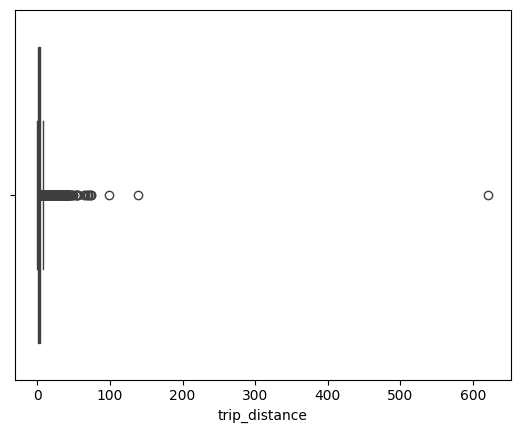

In [423]:
sns.boxplot(x=green_taxi_df_clean_outliers['trip_distance'])


#### almost all values fall within the range 0-100 so we can first remove the value beyond that then take a closer look 

In [424]:
green_taxi_df_clean_outliers[(green_taxi_df_clean_outliers['trip_distance'] >100 )].shape

(2, 23)

In [425]:
green_taxi_df_clean_outliers = green_taxi_df_clean_outliers[green_taxi_df_clean_outliers['trip_distance'] < 100]

In [426]:
green_taxi_df_clean_outliers[(green_taxi_df_clean_outliers['trip_distance'] >100 )].shape

(0, 23)

<Axes: xlabel='trip_distance'>

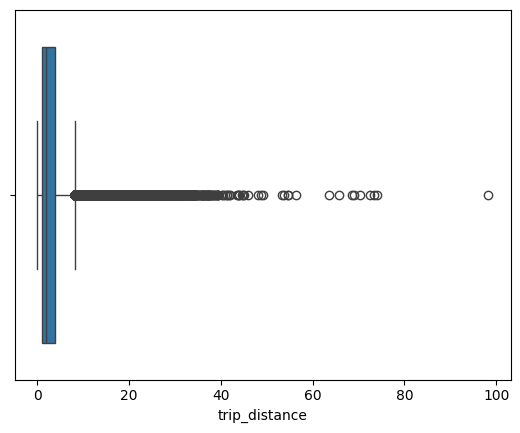

In [427]:
sns.boxplot(x=green_taxi_df_clean_outliers['trip_distance'])

In [428]:
z = np.abs(stats.zscore(green_taxi_df_clean_outliers['trip_distance']))
filtered_entries = z < 3.5
print(1-(green_taxi_df_clean_outliers[filtered_entries].shape[0]/ green_taxi_df_clean_outliers.shape[0]))

0.017650202970925233


#### a zscore of 3.5 seems to find a good balance between keeping the majority of the data so that expensive trips are not needlessly detected as outliers while still detecting outliers that are far from the mean.

#### we will replace them by capping them at the 3.5 zscore value

C:\Users\wagdy\AppData\Local\Temp\ipykernel_18760\1812731733.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  max_within_threshold = df[filtered_entries]["trip_distance"].max()


count    780161.000000
mean          3.180319
std           3.268951
min           0.010000
25%           1.100000
50%           1.970000
75%           3.900000
max          16.090000
Name: trip_distance_imputed, dtype: float64

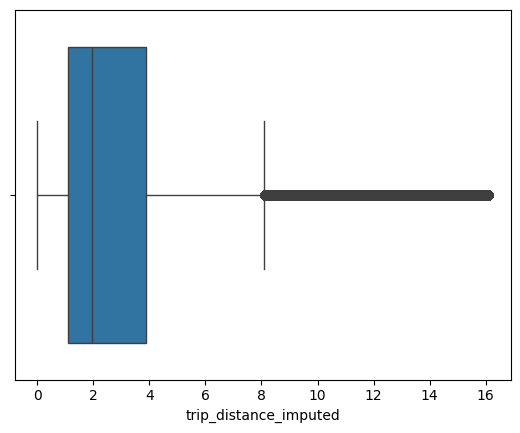

In [429]:
def handle_trip_distance_outliers(df):
    # Calculate Z-scores for the specified column
    z = np.abs(stats.zscore(green_taxi_df_clean['trip_distance']))
    filtered_entries = z < 3.5
    
    # Impute outliers with the maximum value within Z-score threshold
    max_within_threshold = df[filtered_entries]["trip_distance"].max()
    df["trip_distance_imputed"] = df["trip_distance"]
    df.loc[~filtered_entries, "trip_distance_imputed"] = max_within_threshold
    
    return df
green_taxi_df_clean_outliers = handle_trip_distance_outliers(green_taxi_df_clean_outliers)
sns.boxplot(x=green_taxi_df_clean_outliers['trip_distance_imputed'])
green_taxi_df_clean_outliers.trip_distance_imputed.describe()

## fare_amount

#### at first glance there are clear outliers to the right ,we use the zscore with a suitable cutoff(3.5) to detect them and replace them with the cutoff value.

count    780161.000000
mean         13.778720
std          11.591533
min           0.010000
25%           6.500000
50%          10.000000
75%          16.500000
max        2126.690000
Name: fare_amount, dtype: float64

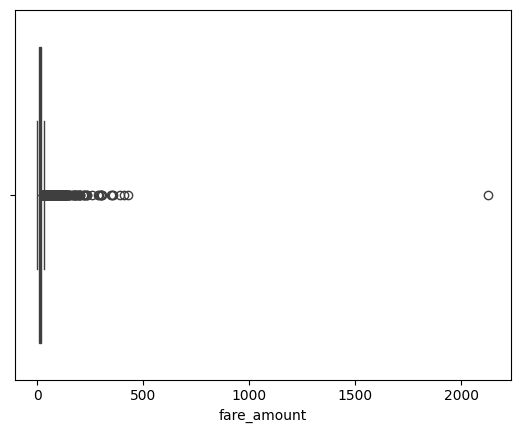

In [430]:
sns.boxplot(x=green_taxi_df_clean_outliers['fare_amount'])
green_taxi_df_clean_outliers["fare_amount"].describe()

In [431]:
z = np.abs(stats.zscore(green_taxi_df_clean_outliers['fare_amount']))
filtered_entries = z < 3.5
print(1-(green_taxi_df_clean_outliers[filtered_entries].shape[0]/ green_taxi_df_clean_outliers.shape[0]))

0.01385867788828199


C:\Users\wagdy\AppData\Local\Temp\ipykernel_18760\1081567237.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  max_within_threshold = df[filtered_entries]["fare_amount"].max()


count    780161.000000
mean         13.607071
std          10.462523
min           0.010000
25%           6.500000
50%          10.000000
75%          16.500000
max          54.310000
Name: fare_amount_imputed, dtype: float64

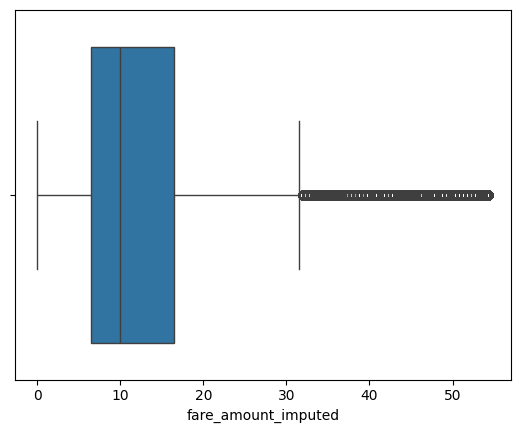

In [432]:
def handle_fare_amount_outliers(df):
    # Calculate Z-scores for the specified column
    z = np.abs(stats.zscore(green_taxi_df_clean['fare_amount']))
    filtered_entries = z < 3.5
    
    # Impute outliers with the maximum value within Z-score threshold
    max_within_threshold = df[filtered_entries]["fare_amount"].max()
    df["fare_amount_imputed"] = df["fare_amount"]
    df.loc[~filtered_entries, "fare_amount_imputed"] = max_within_threshold
    
    return df
green_taxi_df_clean_outliers = handle_fare_amount_outliers(green_taxi_df_clean_outliers)
sns.boxplot(x=green_taxi_df_clean_outliers['fare_amount_imputed'])
green_taxi_df_clean_outliers.fare_amount_imputed.describe()

## extra(we work on the imputed column)

#### these are extra charges for rush hours and overnight and other things so we will keep them regardless of distribution

<Axes: xlabel='extra_imp'>

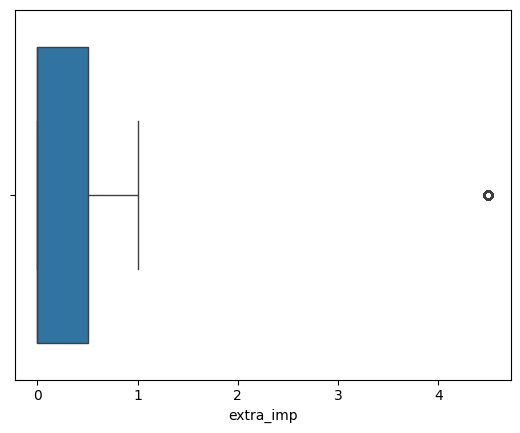

In [433]:
sns.boxplot(x=green_taxi_df_clean_outliers['extra_imp'])


In [434]:
green_taxi_df_clean_outliers["extra_imp"].value_counts()

extra_imp
0.0    413388
0.5    215522
1.0    150945
4.5       306
Name: count, dtype: int64

## mta_tax

#### no outliers as both categories are important although the distribution is unbalanced


In [435]:
green_taxi_df_clean["mta_tax"].value_counts()

mta_tax
0.5    771345
0.0      8825
Name: count, dtype: int64

## tip_amount

#### we observe that there are clear outliers in the tip_amount and therefore we use the iqr method to detect them and replace them with the cutoff value.however we use a bit of a bigger cutoff value(3) as we want to keep some of the outlier values as they are not too far from the mean.

<Axes: xlabel='tip_amount'>

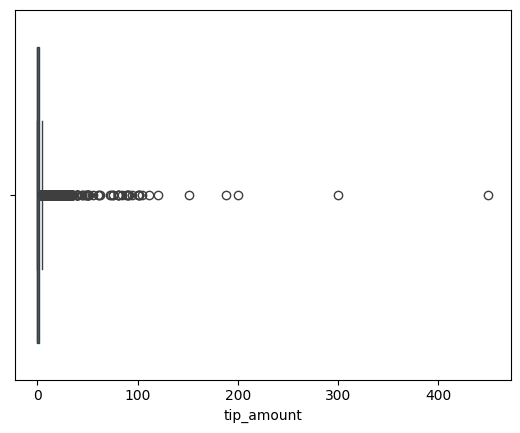

In [436]:
sns.boxplot(x=green_taxi_df_clean_outliers['tip_amount'])

In [437]:
Q1 = green_taxi_df_clean_outliers['tip_amount'].quantile(0.25)
Q3 = green_taxi_df_clean_outliers['tip_amount'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 3 * IQR
green_taxi_df_clean_outliers[green_taxi_df_clean_outliers['tip_amount'] > upper_limit].shape[0]/ green_taxi_df_clean_outliers.shape[0]

0.015541663836054353

<Axes: xlabel='tip_amount'>

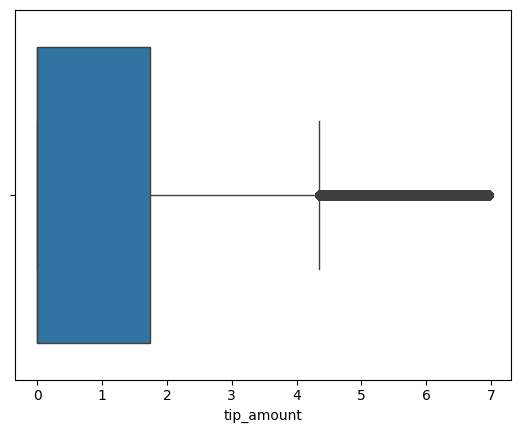

In [438]:
def handle_tip_amount_iqr(df):
    # Calculate the IQR (Interquartile Range)
    Q1 = df["tip_amount"].quantile(0.25)
    Q3 = df["tip_amount"].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outliers
    upper_bound = Q3 + 3 * IQR
    
    # Identify outliers based on IQR bounds
    outliers_mask = (df["tip_amount"] > upper_bound)
    
    # Impute outliers with the upper limit of the IQR
    upper_limit = Q3 + 3 * IQR
    df.loc[outliers_mask, "tip_amount"] = upper_limit
    
    return df
green_taxi_df_clean_outliers = handle_tip_amount_iqr(green_taxi_df_clean_outliers)
sns.boxplot(x=green_taxi_df_clean_outliers['tip_amount'])

## tolls_amount

#### we observe that almost all values fall between 0 and 5.76 so we use it as an upper limit and replace the outliers with it.

In [439]:
green_taxi_df_clean_outliers["tolls_amount"].value_counts()

tolls_amount
0.00     756040
5.76      21203
2.64       1332
2.16        517
11.52       377
          ...  
26.66         1
70.00         1
16.50         1
8.25          1
11.08         1
Name: count, Length: 89, dtype: int64

<Axes: xlabel='tolls_amount'>

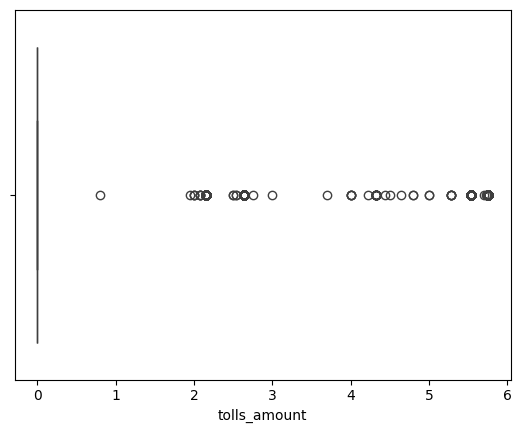

In [440]:
def handle_tolls_amount(df):
    # Calculate the IQR (Interquartile Range)
    
    # Define lower and upper bounds for outliers
    
    # Identify outliers based on IQR bounds
    outliers_mask = (df["tolls_amount"] > 5.76)
    
    # Impute outliers with the upper limit of the IQR
    upper_limit = 5.76
    df.loc[outliers_mask, "tolls_amount"] = upper_limit
    
    return df

green_taxi_df_clean_outliers = handle_tolls_amount(green_taxi_df_clean_outliers)
sns.boxplot(x=green_taxi_df_clean_outliers['tolls_amount'])

## improvement_surcharge

#### no outliers as both categories are important although the distribution is unbalanced


In [441]:
green_taxi_df_clean_outliers["improvement_surcharge"].value_counts()

improvement_surcharge
0.3    771790
0.0      8371
Name: count, dtype: int64

## total_amount

#### Used the same method as fare_amount as it's the total of all the other money related features.

count    780161.000000
mean         16.136303
std          12.682974
min           0.010000
25%           8.300000
50%          11.870000
75%          19.300000
max        2126.690000
Name: total_amount, dtype: float64

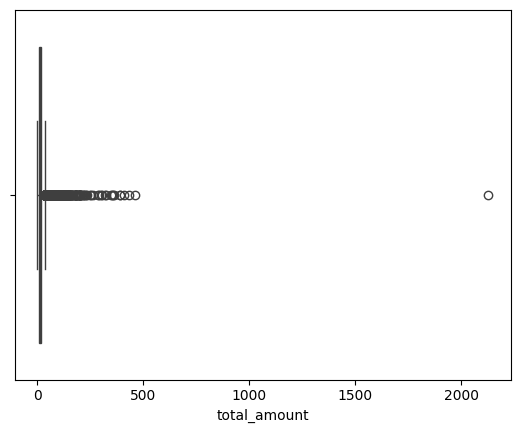

In [442]:
sns.boxplot(x=green_taxi_df_clean_outliers['total_amount'])
green_taxi_df_clean_outliers["total_amount"].describe()

In [443]:
z = np.abs(stats.zscore(green_taxi_df_clean_outliers['total_amount']))
filtered_entries = z < 3.5
print(1-(green_taxi_df_clean_outliers[filtered_entries].shape[0]/ green_taxi_df_clean_outliers.shape[0]))

0.014429072973399126


C:\Users\wagdy\AppData\Local\Temp\ipykernel_18760\2454904988.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  max_within_threshold = df[filtered_entries]["total_amount"].max()


count    780161.000000
mean         15.942532
std          11.448146
min           0.010000
25%           8.300000
50%          11.870000
75%          19.300000
max          60.560000
Name: total_amount, dtype: float64

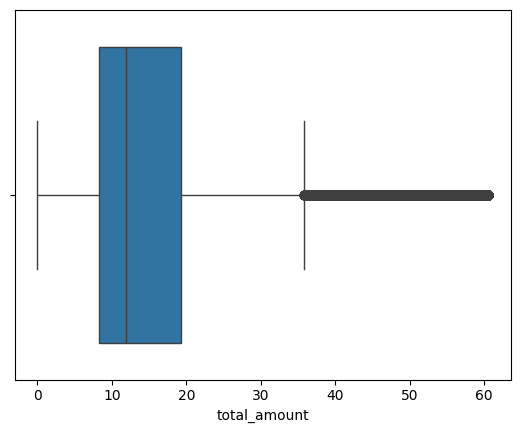

In [444]:
def handle_total_amount_outliers(df):
    # Calculate Z-scores for the specified column
    z = np.abs(stats.zscore(green_taxi_df_clean['total_amount']))
    filtered_entries = z < 3.5
    
    # Impute outliers with the maximum value within Z-score threshold
    max_within_threshold = df[filtered_entries]["total_amount"].max()
    df.loc[~filtered_entries, "total_amount"] = max_within_threshold
    
    return df
green_taxi_df_clean_outliers = handle_total_amount_outliers(green_taxi_df_clean_outliers)
sns.boxplot(x=green_taxi_df_clean_outliers['total_amount'])
green_taxi_df_clean_outliers.total_amount.describe()

## payment_type

#### no outliers as all categories are important although the distribution is unbalanced

In [445]:
green_taxi_df_clean_outliers["payment_type"].value_counts()

payment_type
Credit card    443823
Cash           333497
No charge        1754
Dispute          1087
Name: count, dtype: int64

## trip_type

#### no outliers as both categories are important although the distribution is unbalanced


In [446]:
green_taxi_df_clean_outliers["trip_type"].value_counts()

trip_type
Street-hail    771832
Dispatch         8329
Name: count, dtype: int64

# 4 - Data transformation and feature eng.

## 4.1 - Discretization

In [447]:
green_taxi_df_clean_outliers_engineered = green_taxi_df_clean_outliers.copy()

In [448]:
def generate_date_features(df):
    # Create 'week_number' column
    df['week_number'] = df["lpep_pickup_datetime"].dt.isocalendar().week
    
    # Create 'date_range' column
    df['date_range'] = df["lpep_pickup_datetime"].dt.to_period('W')
    
    return df


green_taxi_df_clean_outliers_engineered = generate_date_features(green_taxi_df_clean_outliers_engineered)


In [449]:
green_taxi_df_clean_outliers_engineered["week_number"].value_counts()
green_taxi_df_clean_outliers_engineered["date_range"].value_counts()

date_range
2018-05-07/2018-05-13    183241
2018-05-14/2018-05-20    178020
2018-05-21/2018-05-27    169217
2018-04-30/2018-05-06    160618
2018-05-28/2018-06-03     89065
Freq: W-SUN, Name: count, dtype: int64

## 4.2 - Adding more features(feature eng.)

In [450]:
def generate_time_features(df):
    # Create 'is_weekend' column (1 for weekend, 0 for weekday)
    df['is_weekend'] = df["lpep_pickup_datetime"].dt.dayofweek // 5 == 1
    
    # Create 'is_night' column (1 for night, 0 for day)
    df['is_night'] = (df["lpep_pickup_datetime"].dt.hour < 6) | (df["lpep_pickup_datetime"].dt.hour >= 20)
    
    return df
green_taxi_df_clean_outliers_engineered = generate_time_features(green_taxi_df_clean_outliers_engineered)



# EDA

## questions

#### 1- what is the rush hour or peak time for green taxis?(pick up  and drop off hour added earlier)
#### 2-More trips on weekdays or weekends?
#### 3 most expensive vebndor?
#### 4-what's the most expensive city?
#### 5-is the rush hour affected by weekend vs weekday?
#### 6- which city uses green taxis the most?
#### 7- more trips in the morning or evening?


In [451]:
green_taxi_df_clean_outliers_engineered["pick_up_hour"] = pd.to_datetime(green_taxi_df_clean_outliers_engineered["lpep_pickup_datetime"]).dt.hour
green_taxi_df_clean_outliers_engineered["drop_off_hour"] = pd.to_datetime(green_taxi_df_clean_outliers_engineered["lpep_dropoff_datetime"]).dt.hour

### question 1

<Axes: xlabel='pick_up_hour'>

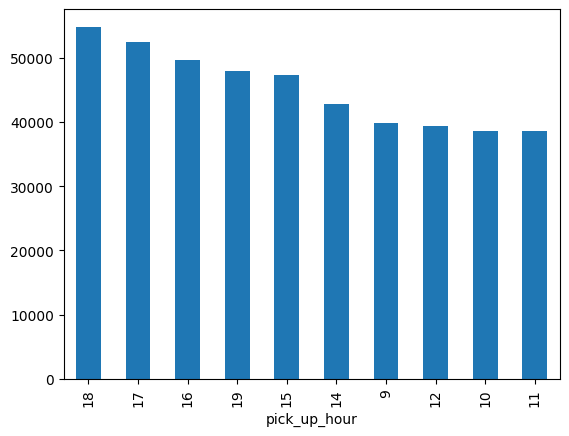

In [452]:
green_taxi_df_clean_outliers_engineered["pick_up_hour"].value_counts().head(10).plot.bar()

### question 2

<Axes: xlabel='is_weekend'>

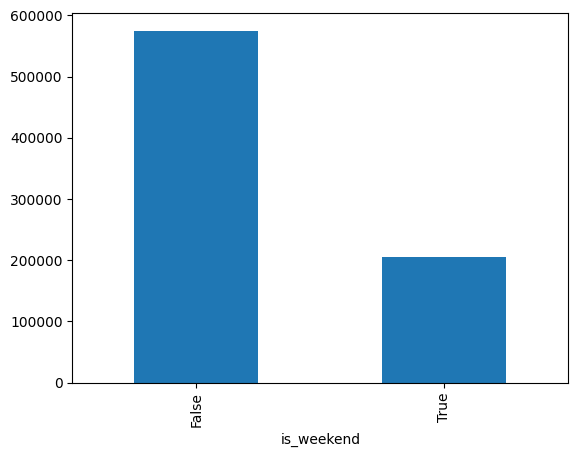

In [453]:
green_taxi_df_clean_outliers_engineered["is_weekend"].value_counts().plot.bar()

### question 3

In [454]:
#which vendor is more expensive
green_taxi_df_clean_outliers_engineered.groupby("vendor")["total_amount"].mean()

vendor
Creative Mobile Technologies, LLC    14.861782
VeriFone Inc.                        16.154990
Name: total_amount, dtype: float64

### question 4

In [455]:
green_taxi_df_clean_outliers_engineered.groupby("pu_location_borough")["total_amount"].mean()

pu_location_borough
Bronx            20.998715
Brooklyn         17.870478
Manhattan        13.992613
Queens           14.972302
Staten Island    42.243980
Name: total_amount, dtype: float64

### question 5

<Axes: xlabel='is_weekend,pick_up_hour'>

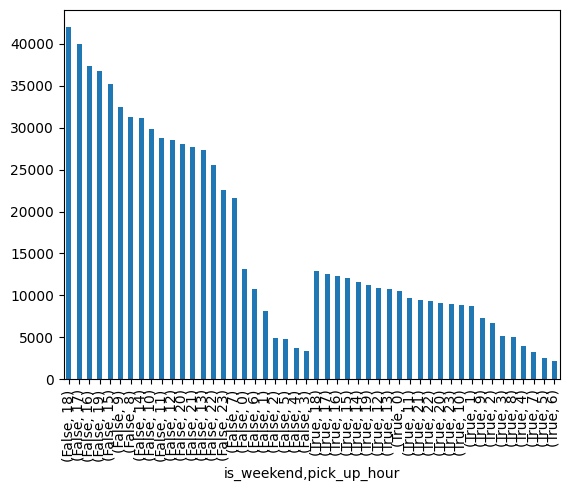

In [456]:
green_taxi_df_clean_outliers_engineered.groupby("is_weekend")["pick_up_hour"].value_counts().plot.bar()

### question 6

<Axes: xlabel='pu_location_borough'>

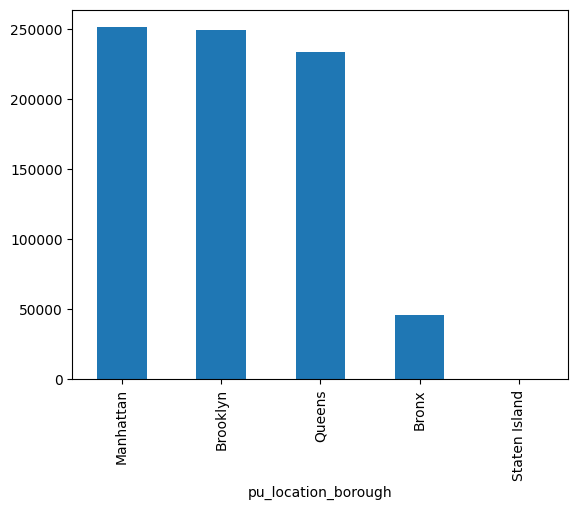

In [457]:
green_taxi_df_clean_outliers_engineered["pu_location_borough"].value_counts().plot.bar()

### question 7

<Axes: xlabel='is_night'>

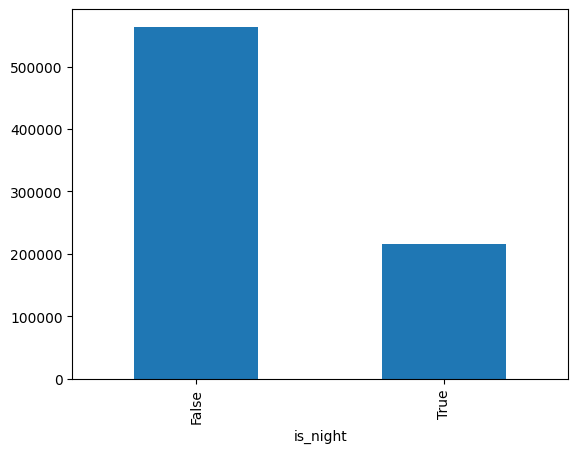

In [458]:
green_taxi_df_clean_outliers_engineered["is_night"].value_counts().plot.bar()

## 4.3 - Encoding

#### features that are binary were encoded using label encoder as they are ordinal features assuming true has more value that false,otherwise we would have used one hot encoding as there's no heirarchy between the values.
#### original columns were kept

In [459]:
green_taxi_df_clean_outliers_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780161 entries, 0 to 796564
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   vendor                 780161 non-null  object        
 1   lpep_pickup_datetime   780161 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  780161 non-null  datetime64[ns]
 3   store_and_fwd_flag     780161 non-null  object        
 4   rate_type              780161 non-null  object        
 5   pu_location            780161 non-null  object        
 6   do_location            780161 non-null  object        
 7   passenger_count        780161 non-null  int32         
 8   trip_distance          780161 non-null  float64       
 9   fare_amount            780161 non-null  float64       
 10  extra                  366773 non-null  float64       
 11  mta_tax                780161 non-null  float64       
 12  tip_amount             780161 non-null  float64  

In [461]:

def encode_features(df):
    result = df.copy() # take a copy of the dataframe
    label_encoding_columns = ['store_and_fwd_flag']
    one_hot_encoding_columns = ['vendor',"rate_type", "payment_type", 'trip_type']
    # apply label encoding to the specified columns
    label_encoder = preprocessing.LabelEncoder()
    for col in label_encoding_columns:
        result[col] = label_encoder.fit_transform(result[col])

    # apply one-hot encoding to the specified columns using get_dummies
    one_hot_encoding_df = pd.get_dummies(result[one_hot_encoding_columns])
    
    result = pd.concat([result, one_hot_encoding_df], axis=1)
    

    return result

green_taxi_df_clean_outliers_engineered_encoded = encode_features(green_taxi_df_clean_outliers_engineered)
green_taxi_df_clean_outliers_engineered_encoded.info()


<class 'pandas.core.frame.DataFrame'>
Index: 780161 entries, 0 to 796564
Data columns (total 45 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   vendor                                    780161 non-null  object        
 1   lpep_pickup_datetime                      780161 non-null  datetime64[ns]
 2   lpep_dropoff_datetime                     780161 non-null  datetime64[ns]
 3   store_and_fwd_flag                        780161 non-null  int32         
 4   rate_type                                 780161 non-null  object        
 5   pu_location                               780161 non-null  object        
 6   do_location                               780161 non-null  object        
 7   passenger_count                           780161 non-null  int32         
 8   trip_distance                             780161 non-null  float64       
 9   fare_amount         

In [462]:
green_taxi_df_clean_outliers_engineered["vendor"].value_counts()

vendor
VeriFone Inc.                        651990
Creative Mobile Technologies, LLC    128171
Name: count, dtype: int64

## 4.4 - Normalisation 

#### we used minmax scaler as it's the most suitable for our data as it's not normally distributed and we scaled all numerical columns that have a big range of values to make sure they have the same effect on the model.

In [463]:
def scale_features(df):
    result = df.copy() # take a copy of the dataframe
    columns_to_scale = ["trip_distance","fare_amount","tip_amount","total_amount"]
    # apply min-max scaling to the specified columns
    scaler = MinMaxScaler()
    result[columns_to_scale] = scaler.fit_transform(result[columns_to_scale])
    
    return result

green_taxi_df_clean_outliers_engineered_encoded_scaled = scale_features(green_taxi_df_clean_outliers_engineered_encoded)

## 4.5 - Additional data extraction (GPS coordinates)

In [464]:
from opencage.geocoder import OpenCageGeocode

# Replace 'YOUR_API_KEY' with your actual OpenCage Geocoding API key
api_key = "e5370232998a4369b116891cd3297584"

def get_unique_coordinates(unique_locations):
    geocoder = OpenCageGeocode(api_key)
    coordinates_dict = {}

    for location in unique_locations:
        results = geocoder.geocode(location)
        if results and len(results):
            coordinates_dict[location] = {
                'latitude': results[0]['geometry']['lat'],
                'longitude': results[0]['geometry']['lng']
            }

    return coordinates_dict


def add_coordinates_to_dataframe(df):
    unique_pickup_locations = df["pu_location"].unique()
    unique_dropoff_locations = df["do_location"].unique()
    unique_locations = np.unique(np.concatenate((unique_pickup_locations, unique_dropoff_locations), axis=0))


    unique_coordinates = get_unique_coordinates(unique_locations)
    # dropoff_coordinates = get_unique_coordinates(unique_dropoff_locations)

    df['pu_latitude'] = df["pu_location"].map(lambda x: unique_coordinates.get(x, {}).get('latitude'))
    df['pu_longitude'] = df["pu_location"].map(lambda x: unique_coordinates.get(x, {}).get('longitude'))
    df['do_latitude'] = df["do_location"].map(lambda x: unique_coordinates.get(x, {}).get('latitude'))
    df['do_longitude'] = df["do_location"].map(lambda x: unique_coordinates.get(x, {}).get('longitude'))

    return df

green_taxi_df_clean_outliers_engineered_encoded_scaled_with_coordinates = add_coordinates_to_dataframe(green_taxi_df_clean_outliers_engineered_encoded_scaled)



In [465]:
green_taxi_df_clean_outliers_engineered_encoded_scaled_with_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780161 entries, 0 to 796564
Data columns (total 49 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   vendor                                    780161 non-null  object        
 1   lpep_pickup_datetime                      780161 non-null  datetime64[ns]
 2   lpep_dropoff_datetime                     780161 non-null  datetime64[ns]
 3   store_and_fwd_flag                        780161 non-null  int32         
 4   rate_type                                 780161 non-null  object        
 5   pu_location                               780161 non-null  object        
 6   do_location                               780161 non-null  object        
 7   passenger_count                           780161 non-null  int32         
 8   trip_distance                             780161 non-null  float64       
 9   fare_amount         

## 5- Exporting the dataframe to a csv file or parquet

In [466]:
green_taxi_df_clean_outliers_engineered_encoded_scaled_with_coordinates.to_csv('../dataset/cleaned_data.csv',index=False)